### Import Libraries and Data

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [15]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/Downloads/HDFCBANK.csv')
dataset.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(5306, 15)

#### Find the Earliest and Latest Date in the Dataset

In [71]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.index = dataset['Date']
print(f'Earliest:{dataset.index.max()}')
print(f'Latest:{dataset.index.min()}')

Earliest:2021-04-30 00:00:00
Latest:2000-01-03 00:00:00


**We will use only five years of Closing Prices**

In [95]:
df = dataset.loc[dataset.index >= datetime(2018, 1, 1),'Close'].copy()
df.shape

(823,)

#### Train and Test Split

In [96]:
df_train = df.loc[df.index < datetime(2021, 1,1)]
df_test = df.loc[df.index >= datetime(2021, 1,1)]
print(f'Observations in Train Set:{df_train.shape}')
print(f'Observations in Test Set:{df_test.shape}')

Observations in Train Set:(743,)
Observations in Test Set:(80,)


**Reshape the datasets from 1D to 2D array**

In [97]:
df_train = np.reshape(df_train, (-1,1))
df_test = np.reshape(df_test, (-1,1))

**Scale the train dataset**

In [98]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.fit_transform(df_test)


*The time-series data must be divided into X_train and y_train from the training set and X_test and y_test from the testing set in this phase. It is done to turn time series data into a supervised learning problem that can be utilized to train the model. The loop generates input/output sequences of length 50 while iterating through the time series data. Using this method, we can forecast future values while taking into consideration the data’s temporal dependence on prior observations.*

In [99]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
	X_train.append(scaled_train[i-50:i, 0])
	y_train.append(scaled_train[i, 0])
	if i <= 51:
		print(X_train)
		print(y_train)
		print()

[array([0.62919007, 0.63952411, 0.62811903, 0.63231633, 0.6344584 ,
       0.63272159, 0.6345163 , 0.63480577, 0.6396399 , 0.6354426 ,
       0.65422914, 0.6556186 , 0.65003184, 0.67538934, 0.68575233,
       0.69220749, 0.68523129, 0.68890754, 0.69892317, 0.71322295,
       0.71082036, 0.71672553, 0.70830197, 0.68332079, 0.66355005,
       0.65367915, 0.63978463, 0.64450298, 0.62629537, 0.64201355,
       0.64577665, 0.64505297, 0.64314248, 0.6429109 , 0.63422683,
       0.63086899, 0.62843745, 0.64427141, 0.66221849, 0.65700805,
       0.64638453, 0.64068199, 0.63813466, 0.62441383, 0.61651132,
       0.62823482, 0.62719273, 0.63657153, 0.63251896, 0.63497945])]
[0.6444161407977766]

[array([0.62919007, 0.63952411, 0.62811903, 0.63231633, 0.6344584 ,
       0.63272159, 0.6345163 , 0.63480577, 0.6396399 , 0.6354426 ,
       0.65422914, 0.6556186 , 0.65003184, 0.67538934, 0.68575233,
       0.69220749, 0.68523129, 0.68890754, 0.69892317, 0.71322295,
       0.71082036, 0.71672553, 0.708

In [100]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
	X_test.append(scaled_test[i-50:i, 0])
	y_test.append(scaled_test[i, 0])


*In this step, the data is converted into a format that is suitable for input to an RNN. np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) transforms the X_train array, which was originally a 2-dimensional array of shape (samples, features), into a 3-dimensional array of shape (samples, time steps, features), where time steps denotes the number of time steps in the input sequence and features denotes the number of features in the input data. Size 1 is an additional dimension that serves as an indication that each time step only has a single feature.* \

*The y_train array is transformed from a 1-dimensional array of shape (samples) into a 2-dimensional array of shape (samples, 1) by np.reshape(y_train, (y_train.shape[0], 1)), where each row represents the output value at a certain time step.*

In [101]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


X_train : (693, 50, 1) y_train : (693, 1)


In [102]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)


X_test : (30, 50, 1) y_test : (30, 1)


### Developing Deep Learning Models

In [103]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


#### Simple RNN
*This code creates a recurrent neural network (RNN) with four layers of basic RNNs and a dense output layer. It makes use of the tanh hyperbolic tangent activation function. To avoid overfitting, a dropout layer with a rate of 0.2 is introduced. It employs the optimizer as Adam, mean squared error as the loss function, and accuracy as the evaluation metric while compiling. With a batch size of 2, it fits the model to the training data for 20 epochs. The number of parameters in each layer and the overall number of parameters in the model are listed in a summary of the model architecture.*

In [104]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								momentum=0.9,
								nesterov=True),
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

Epoch 1/20
347/347 [==============================] - 18s 43ms/step - loss: 0.0150
Epoch 2/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0045
Epoch 3/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0035
Epoch 4/20
347/347 [==============================] - 16s 46ms/step - loss: 0.0033
Epoch 5/20
347/347 [==============================] - 17s 50ms/step - loss: 0.0031
Epoch 6/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0030
Epoch 7/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0024
Epoch 8/20
347/347 [==============================] - 17s 49ms/step - loss: 0.0027
Epoch 9/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0024
Epoch 10/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0022
Epoch 11/20
347/347 [==============================] - 15s 43ms/step - loss: 0.0022
Epoch 12/20
347/347 [==============================] - 15s 42ms/step - loss: 0.0024
E

#### LSTM RNN
*This code creates a LSTM Model with three layers and a dense output layer. It employs the optimizer as Adam, mean squared error as the loss function, and accuracy as the evaluation metric while compiling. With a batch size of 1, it fits the model to the training data for 10 epochs. The number of parameters in each layer and the overall number of parameters in the model are listed in a summary of the model architecture.*

In [105]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50,
					return_sequences = True,
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50,
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train,
				y_train,
				batch_size = 1,
				epochs = 12)
regressorLSTM.summary()

Epoch 1/12
693/693 [==============================] - 25s 30ms/step - loss: 0.0081 - accuracy: 0.0029
Epoch 2/12
693/693 [==============================] - 20s 29ms/step - loss: 0.0034 - accuracy: 0.0029
Epoch 3/12
693/693 [==============================] - 21s 31ms/step - loss: 0.0031 - accuracy: 0.0029
Epoch 4/12
693/693 [==============================] - 19s 28ms/step - loss: 0.0021 - accuracy: 0.0029
Epoch 5/12
693/693 [==============================] - 19s 28ms/step - loss: 0.0022 - accuracy: 0.0029
Epoch 6/12
693/693 [==============================] - 21s 30ms/step - loss: 0.0016 - accuracy: 0.0029
Epoch 7/12
693/693 [==============================] - 19s 27ms/step - loss: 0.0018 - accuracy: 0.0029
Epoch 8/12
693/693 [==============================] - 20s 29ms/step - loss: 0.0015 - accuracy: 0.0029
Epoch 9/12
693/693 [==============================] - 20s 29ms/step - loss: 0.0013 - accuracy: 0.0029
Epoch 10/12
693/693 [==============================] - 19s 28ms/step - loss: 0.001

**Make Predictions**

In [106]:
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)

1/1 [==============================] - 1s 807ms/step


**Scaling Back from 0-1 to Original Values**

In [107]:
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)

In [108]:
y_test.shape

(30, 1)

In [109]:
df_train = df.loc[df.index < datetime(2021, 1,1)]
df_test = df.loc[df.index >= datetime(2021, 1,1)]
df_test.shape

(80,)

#### Visualize Predicted Prices Using

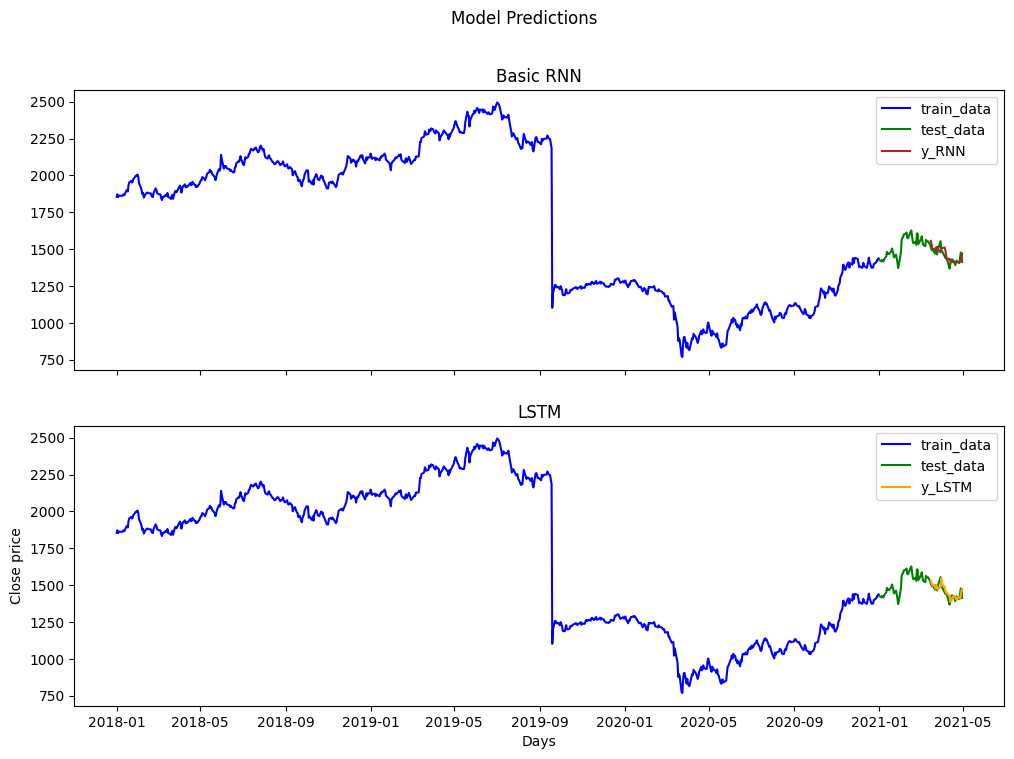

In [110]:
fig, axs = plt.subplots(2,figsize =(12,8),sharex=True, sharey=True)
fig.suptitle('Model Predictions')


#Plot for RNN predictions
axs[0].plot(df_train.index, df_train, label = "train_data", color = "b")
axs[0].plot(df_test.index, df_test, label = "test_data", color = "g")
axs[0].plot(df_test.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(df_train.index, df_train, label = "train_data", color = "b")
axs[1].plot(df_test.index, df_test, label = "test_data", color = "g")
axs[1].plot(df_test.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

# #Plot for GRU predictions
# axs[2].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
# axs[2].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
# axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
# axs[2].legend()
# axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Close price")

plt.show()

**Seems like the LSTM performed better than simple RNN**